<a href="https://colab.research.google.com/github/SruthiMannam/Stock-Market-prediction-using-LSTM/blob/main/Stock_Market_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Load stock data
def load_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

In [ ]:
# Prepare dataset for LSTM
def prepare_data(data, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1], 1), y, scaler

In [ ]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Load data
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-01-01'
stock_data = load_stock_data(ticker, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Prepare data
time_steps = 60
X, y, scaler = prepare_data(stock_data, time_steps)
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [ ]:
# Train LSTM model
model = build_lstm_model((X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0245 - val_loss: 0.0027
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0013 - val_loss: 0.0097
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.9540e-04 - val_loss: 0.0026
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 9.4309e-04 - val_loss: 0.0017
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 8.6446e-04 - val_loss: 0.0012
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 8.1231e-04 - val_loss: 0.0010
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/

In [ ]:
# Predict and visualize
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [ ]:
# Calculate metrics
r2 = r2_score(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
correlation = np.corrcoef(y_test_actual.flatten(), predictions.flatten())[0, 1]

print(f'R2 Score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'Correlation: {correlation}')

R2 Score: 0.9549309170024052
MSE: 15.846298310394362
RMSE: 3.9807409248021104
Correlation: 0.977811386412971


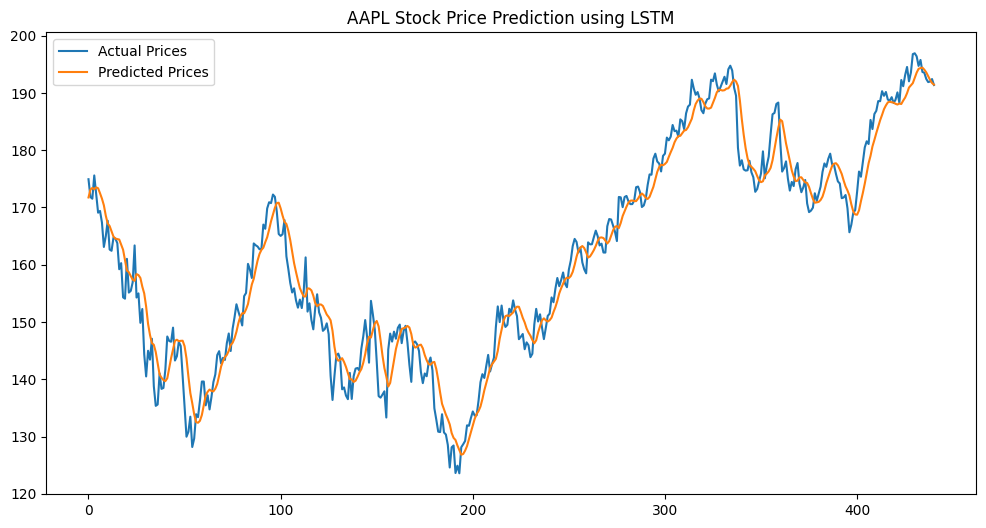

In [ ]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.show()

In [ ]:
# Predict next 100 days
future_predictions = []
last_60_days = X_test[-1]
for _ in range(100):
    pred = model.predict(last_60_days.reshape(1, -1, 1))
    future_predictions.append(pred[0, 0])
    last_60_days = np.roll(last_60_days, -1)
    last_60_days[-1] = pred

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

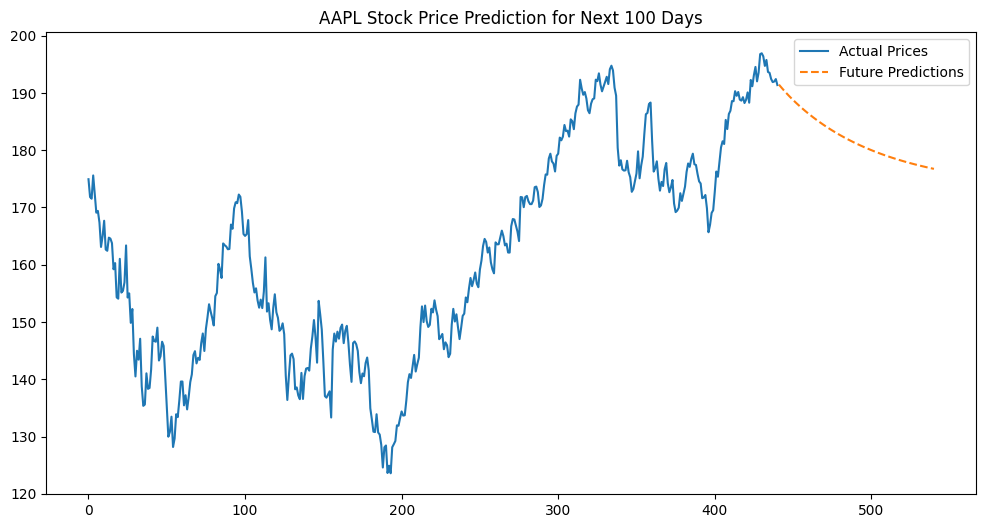

In [ ]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Prices')
plt.plot(range(len(y_test_actual), len(y_test_actual) + 100), future_predictions, label='Future Predictions', linestyle='dashed')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction for Next 100 Days')
plt.show()

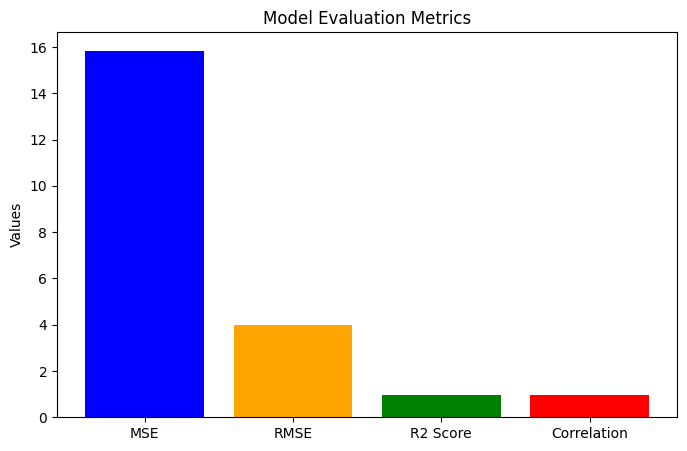

In [ ]:
# Bar plots for evaluation metrics
metrics = ['MSE', 'RMSE', 'R2 Score', 'Correlation']
values = [mse, rmse, r2, correlation]
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Values')
plt.show()